## Load libraries

In [1]:
from dotenv import dotenv_values
import numpy as np
import warnings
import os
import pandas as pd 
import matplotlib.pyplot as plt 
from HurstIndexSolver.HurstIndexSolver  import HurstIndexSolver
from HurstIndexSolver.fgn  import fgn
import yfinance as yf
import warnings
warnings.filterwarnings("ignore")


### Load data and initialize variables

In [2]:
start_date = "2005-01-01"
end_date = "2022-12-31"
df_path = "../data/raw/spy.csv"

In [3]:

config = dotenv_values("../config/.env")

In [4]:
ALPHA_API = config["ALPHA_API"]

In [5]:
def get_df(path:str)->pd.DataFrame:
    if os.path.isfile(path):
        df = pd.read_csv(path, parse_dates=True, index_col=0)
    else:
        df = yf.download("SPY", start=start_date, end=end_date)
        df.to_csv(path)
    return df

In [6]:
spy = get_df(df_path)

In [7]:
spy = spy[spy.index<"31-12-2017"]

### Compute Hurst according to Zhang

In [8]:
HSolver = HurstIndexSolver()

In [9]:
max_scale =100
HSolver.EstHurstLSSD(np.diff(spy["Close"].values), max_scale=max_scale)

0.467446570335479

### Multifractal simulation

In [10]:
from MMAR.MMAR import MMAR 

In [11]:
mmar = MMAR(spy["Close"])

In [12]:
mmar.get_alpha_min()

0.4537228415434479

In [13]:
mmar.get_scaling()

(array([-1.        , -0.99452732, -0.98919268, ...,  4.42712322,
         4.43184726,  4.43657069]),
 array([  1.        ,  -0.05866533,  -0.11344362, ..., -32.30840836,
        -32.33362972, -32.35884921]),
 array([ 0.  ,  0.01,  0.02, ...,  9.98,  9.99, 10.  ]))

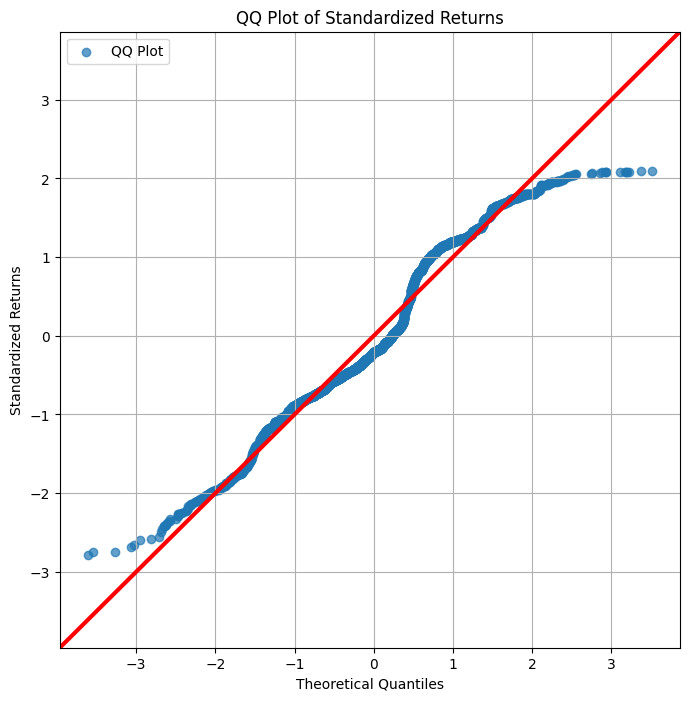

In [14]:
mmar.plot_qq()

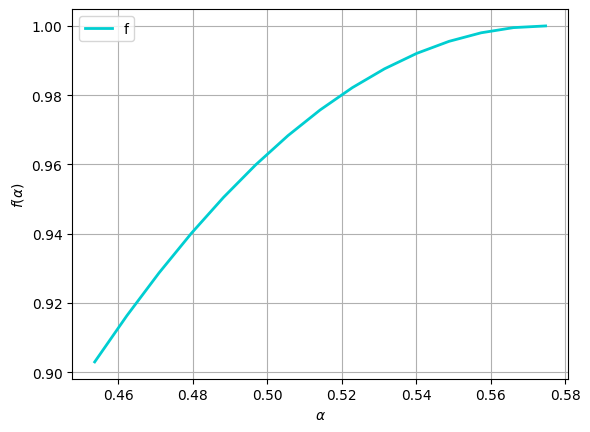

In [15]:
mmar.plot_alpha()

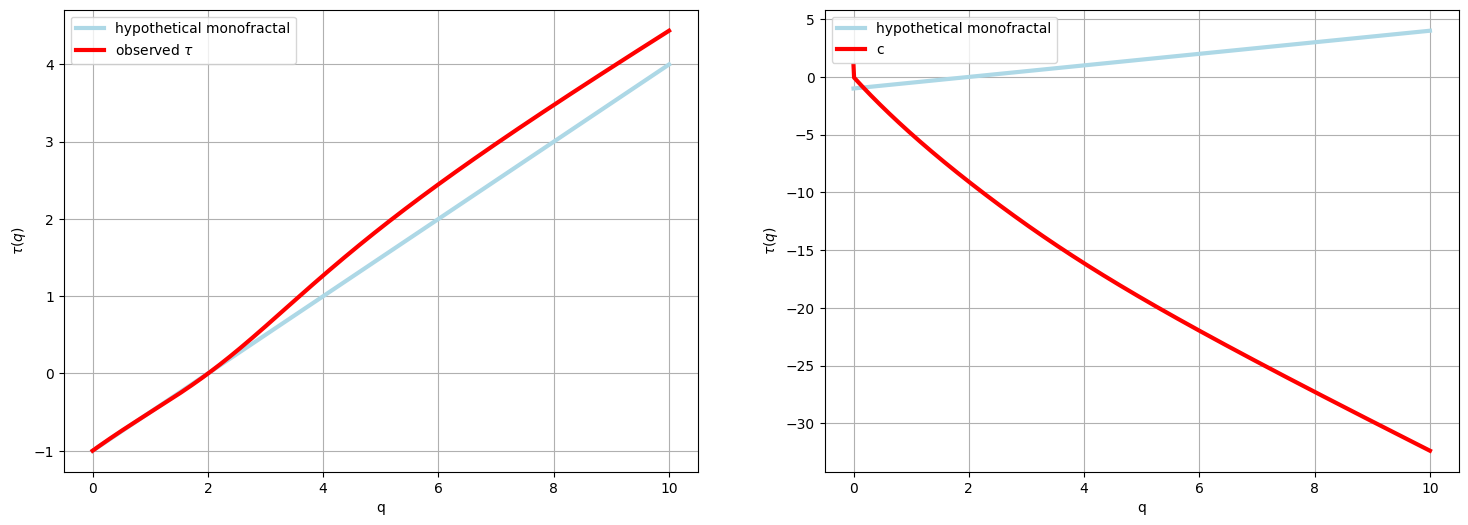

In [16]:
mmar.plot_scaling()

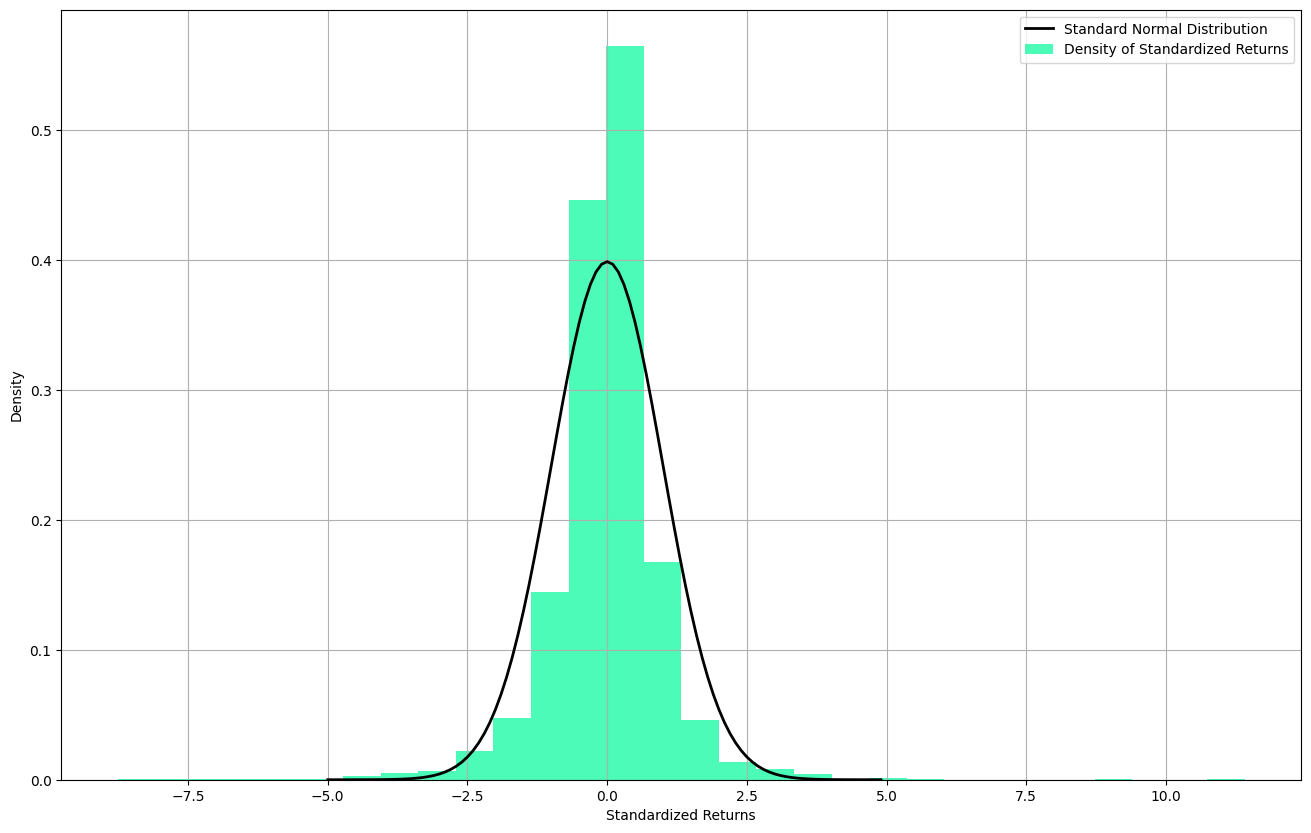

In [17]:
mmar.plot_density()

In [18]:
mmar.H, mmar.theta, mmar.sigma, mmar.mu, mmar.tau

(0.4991659905391841,
 array([0.00018338, 0.00024529, 0.00012281, ..., 0.00052551, 0.0002631 ,
        0.00035192]),
 0.6608710048634898,
 1.1513661836669795,
 array([-1.        , -0.99452732, -0.98919268, ...,  4.42712322,
         4.43184726,  4.43657069]))

In [19]:
mmar.theta.shape

(2048,)

In [20]:
mmar._sigma_ret

0.011857072205161029

In [21]:
mmar.sigma**2

0.43675048506927877

In [22]:
mmar.theta

array([0.00018338, 0.00024529, 0.00012281, ..., 0.00052551, 0.0002631 ,
       0.00035192])

In [23]:
mmar2 = MMAR(spy["Close"])

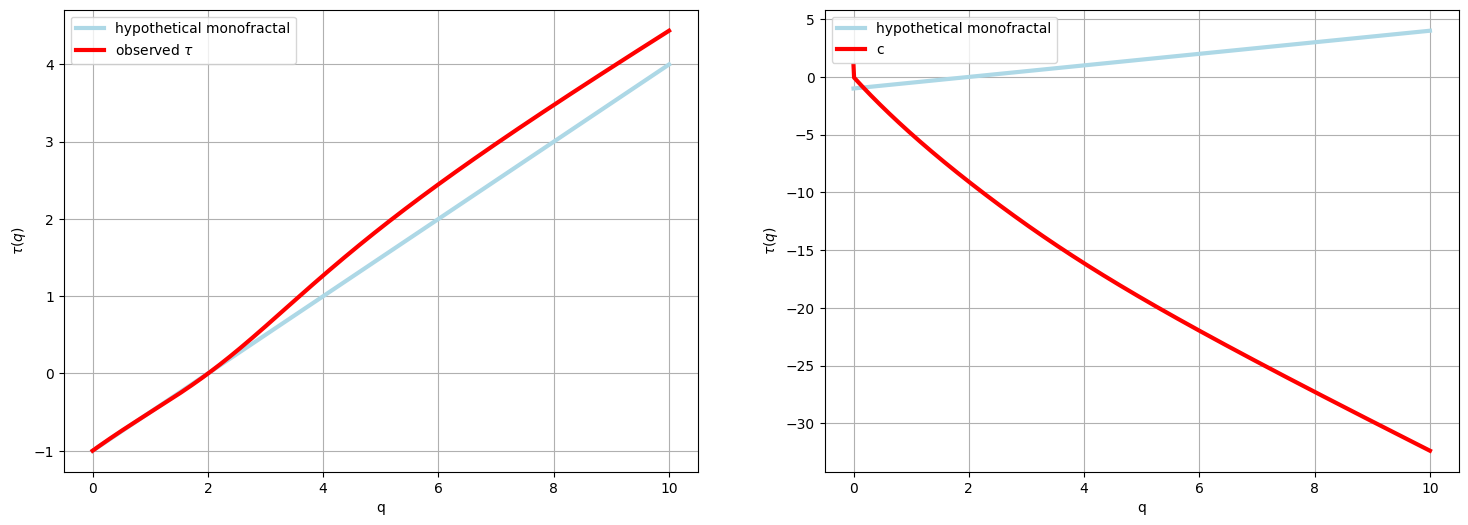

In [24]:
mmar2.plot_scaling()

In [25]:
S0 = spy.Close.iloc[-1]
simulation = mmar.get_MMAR_MC(S0, n=22, num_sim=5_000_000, seed=2048)

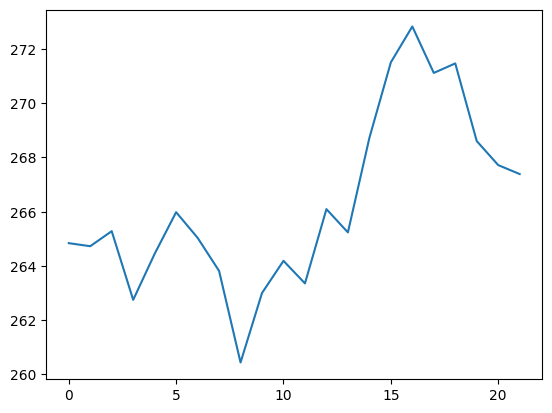

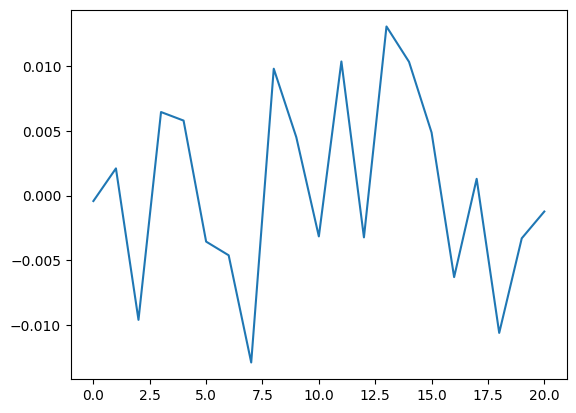

In [26]:
mmar_sim_sample = simulation[0,:]

plt.plot(mmar_sim_sample)
plt.show()

sim_log_diff = np.diff(np.log(mmar_sim_sample))
plt.plot(sim_log_diff)
plt.show()

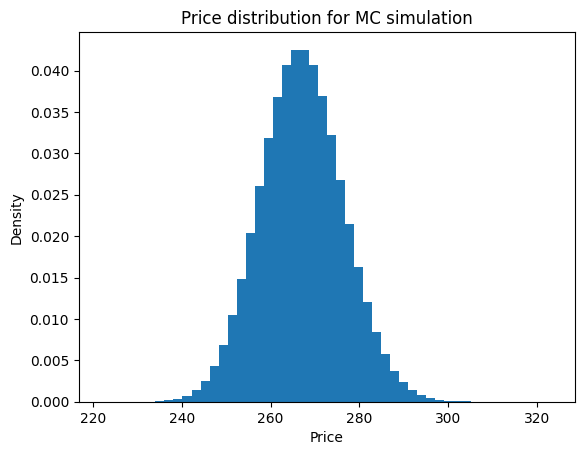

In [27]:
plt.hist(simulation[:,-1:], bins=50, density=True)
plt.xlabel("Price")
plt.ylabel("Density")
plt.title("Price distribution for MC simulation")
plt.show()

In [28]:
def get_call_price(prices, strike, r, T):
    values = prices[prices>strike]
    prob = len(values)/len(prices)
    exp_val = np.mean(values)
    print(f"Probability expected price {exp_val:.2f} > {strike:.2f} is {prob:.2%}")
    return np.exp(-r*T)*prob*(exp_val-strike)

In [29]:
# test stability
S0 = spy.Close.iloc[-1]
for i in range(10):
    simulation = mmar.get_MMAR_MC(S0, n=22, num_sim=1_000_000, seed=i)
    print(round(get_call_price(simulation[:,-1:], 269, 3/100, 22/360),2))

Probability expected price 275.89 > 269.00 is 40.95%
2.82
Probability expected price 275.90 > 269.00 is 40.99%
2.82
Probability expected price 275.89 > 269.00 is 40.97%
2.82
Probability expected price 275.91 > 269.00 is 40.98%
2.82
Probability expected price 275.88 > 269.00 is 40.92%
2.81
Probability expected price 275.89 > 269.00 is 40.99%
2.82
Probability expected price 275.90 > 269.00 is 40.97%
2.82
Probability expected price 275.91 > 269.00 is 40.90%
2.82
Probability expected price 275.90 > 269.00 is 40.86%
2.81
Probability expected price 275.88 > 269.00 is 40.89%
2.81


In [30]:
mmar2 = MMAR(spy["Close"])
# test stability
S0 = spy.Close.iloc[-1]
for i in range(10):
    simulation = mmar2.get_MMAR_MC(S0, n=22, num_sim=1_000_000, seed=i)
    print(round(get_call_price(simulation[:,-1:], 269, 3/100, 22/360),2))

Probability expected price 275.89 > 269.00 is 40.95%
2.82
Probability expected price 275.90 > 269.00 is 40.99%
2.82
Probability expected price 275.89 > 269.00 is 40.97%
2.82
Probability expected price 275.91 > 269.00 is 40.98%
2.82
Probability expected price 275.88 > 269.00 is 40.92%
2.81
Probability expected price 275.89 > 269.00 is 40.99%
2.82
Probability expected price 275.90 > 269.00 is 40.97%
2.82
Probability expected price 275.91 > 269.00 is 40.90%
2.82
Probability expected price 275.90 > 269.00 is 40.86%
2.81
Probability expected price 275.88 > 269.00 is 40.89%
2.81


If we use a different seed for the MMAR object init, we get different values

In [31]:
# The default seed is 42; let's try a different value. We should get a completely different output.
mmar3 = MMAR(spy["Close"], seed=21)
# test stability
S0 = spy.Close.iloc[-1]
for i in range(10):
    simulation = mmar3.get_MMAR_MC(S0, n=22, num_sim=1_000_000, seed=i)
    print(round(get_call_price(simulation[:,-1:], 269, 3/100, 22/360),2))

Probability expected price 276.60 > 269.00 is 41.67%
3.16
Probability expected price 276.58 > 269.00 is 41.75%
3.16
Probability expected price 276.59 > 269.00 is 41.66%
3.15
Probability expected price 276.59 > 269.00 is 41.70%
3.16
Probability expected price 276.58 > 269.00 is 41.62%
3.15
Probability expected price 276.59 > 269.00 is 41.71%
3.16
Probability expected price 276.60 > 269.00 is 41.71%
3.16
Probability expected price 276.59 > 269.00 is 41.68%
3.16
Probability expected price 276.60 > 269.00 is 41.59%
3.16
Probability expected price 276.57 > 269.00 is 41.67%
3.15


### Option chain

In [32]:
opt_chain = pd.read_csv("../data/processed/chain2018.csv.gz",  parse_dates=True)

In [33]:
opt_chain.columns

Index(['QUOTE_DATE', 'UNDERLYING_LAST', 'EXPIRE_DATE', 'DTE', 'C_DELTA',
       'C_GAMMA', 'C_VEGA', 'C_THETA', 'C_RHO', 'C_IV', 'C_VOLUME', 'C_LAST',
       'C_SIZE', 'C_BID', 'C_ASK', 'STRIKE', 'P_BID', 'P_ASK', 'P_SIZE',
       'P_LAST', 'P_DELTA', 'P_GAMMA', 'P_VEGA', 'P_THETA', 'P_RHO', 'P_IV',
       'P_VOLUME', 'STRIKE_DISTANCE', 'STRIKE_DISTANCE_PCT'],
      dtype='object')

In [34]:
opt_chain.query('(EXPIRE_DATE=="2018-02-02")&(QUOTE_DATE=="2018-01-02")')[["UNDERLYING_LAST","STRIKE",  'C_LAST',
       'C_BID', 'C_ASK', 'C_IV', 'C_SIZE', 'C_VOLUME',]]

,UNDERLYING_LAST,STRIKE,C_LAST,C_BID,C_ASK,C_IV,C_SIZE,C_VOLUME
511,268.81,232.5,0.00,36.58,36.77,0.31245,30 x 28,NaN
512,268.81,235.0,0.00,34.09,34.29,0.29239,30 x 10,NaN
513,268.81,237.5,31.04,31.60,31.81,0.27423,20 x 10,2.0
514,268.81,240.0,28.10,29.13,29.33,0.25597,20 x 19,0.0
515,268.81,242.5,0.00,26.66,26.86,0.23967,20 x 29,NaN
516,268.81,245.0,0.00,24.20,24.40,0.22240,20 x 19,NaN
517,268.81,247.5,0.00,21.73,21.93,0.20563,20 x 29,NaN
518,268.81,250.0,0.00,19.29,19.48,0.19093,19 x 20,NaN
519,268.81,252.5,0.00,16.66,17.27,0.17623,253 x 253,NaN
520,268.81,255.0,13.78,14.41,14.60,0.15771,19 x 20,1.0


### Example strategy

In [35]:
quote_dates=[
 '2018-01-02',
 '2018-02-02',
 '2018-03-02',
 '2018-04-02',
 '2018-05-02',
 '2018-06-01',
 '2018-07-02',
 '2018-08-01',
 '2018-09-04',
 '2018-10-03',
 '2018-11-02',
 '2018-12-03']

In [36]:
exp_dates = [
 '2018-02-02',
 '2018-03-02',
 '2018-04-02',
 '2018-05-02',
 '2018-06-01',
 '2018-07-02',
 '2018-08-01',
 '2018-09-04',
 '2018-10-03',
 '2018-11-02',
 '2018-12-03',
 ]

Define a simple strategy. If the expected call price given our simulation is bigger than the market price, buy, otherwise sell.

In [37]:
def compute_strategy(chain:pd.DataFrame, path:str,dates:tuple[str,str], n:int=22, num_sim:int=10_000, r:float=0.01, seed:int=1968):
    spy = get_df(path)
    result = {}
    for i, date in enumerate(dates):
        quote_date = date[0]
        expire_date = date[1]
        df = chain.query('(EXPIRE_DATE==@expire_date)&(QUOTE_DATE==@quote_date)')[[ "UNDERLYING_LAST", "STRIKE", 'C_LAST','C_BID', 'C_ASK', 'C_IV', 'C_SIZE', 'C_VOLUME']]
        current_price = df.iloc[0,0]
        strike = np.ceil(current_price)
        s = 0.0
        while len(df[df.STRIKE == strike]["C_LAST"])==0:
            s+=1.0
            strike = np.ceil(current_price+s)
        call = df[df.STRIKE == strike]["C_LAST"].iloc[0]
        mmar = MMAR(spy[spy.index<quote_date]["Close"])
        simulation = mmar.get_MMAR_MC(current_price, n=n, num_sim=num_sim, seed=seed)
        exp_call = np.round(get_call_price(simulation[:,-1:], strike, r, n/360),2)
        result[i]={"quote_date": quote_date, "exp_date":expire_date,  "call":call, "exp_call":exp_call, "strike":strike, "price":current_price}
    return result

In [38]:
backtest = compute_strategy(opt_chain, df_path, zip(quote_dates, exp_dates), 22, 5_000_000, 1/100)

Probability expected price 276.59 > 269.00 is 49.25%
Probability expected price 283.72 > 276.00 is 48.07%
Probability expected price 277.37 > 270.00 is 46.25%
Probability expected price 266.53 > 260.00 is 39.31%
Probability expected price 271.21 > 264.00 is 46.50%
Probability expected price 281.62 > 274.00 is 48.50%
Probability expected price 279.68 > 272.00 is 50.06%
Probability expected price 288.87 > 281.00 is 49.69%
Probability expected price 298.09 > 290.00 is 49.50%
Probability expected price 300.06 > 292.00 is 48.94%
Probability expected price 279.68 > 272.00 is 49.09%


In [39]:
backtest = pd.DataFrame.from_dict(backtest, orient="index")
backtest["exp_price"] = backtest.price.shift(-1)
backtest

,quote_date,exp_date,call,exp_call,strike,price,exp_price
0,2018-01-02,2018-02-02,2.14,3.74,269.0,268.81,275.52
1,2018-02-02,2018-03-02,4.35,3.71,276.0,275.52,269.10
2,2018-03-02,2018-04-02,3.80,3.41,270.0,269.10,257.54
3,2018-04-02,2018-05-02,4.83,2.57,260.0,257.54,263.18
4,2018-05-02,2018-06-01,3.80,3.35,264.0,263.18,273.63
5,2018-06-01,2018-07-02,2.49,3.70,274.0,273.63,272.00
6,2018-07-02,2018-08-01,3.88,3.84,272.0,272.00,280.91
7,2018-08-01,2018-09-04,3.43,3.91,281.0,280.91,289.86
8,2018-09-04,2018-10-03,2.75,4.00,290.0,289.86,291.72
9,2018-10-03,2018-11-02,3.15,3.94,292.0,291.72,271.77


In [40]:
# In this short simualtion I used only 2018 data and excluded the last row since the exp_price is NaN.
profit = 0.0
for row in backtest.iloc[:-1,:].itertuples():  
    if row.exp_call > row.call:
        profit += (max(row.exp_price-row.strike,0)-row.call)
        print(f"for date {row.quote_date} and expire date {row.exp_date}, the profit is {max(row.exp_price-row.strike,0)-row.call:.2f}")
    else:
        profit += (min(row.strike-row.exp_price,0)+row.call)
        print(f"for date {row.quote_date} and expire date {row.exp_date} the profit is {min(row.strike-row.exp_price,0)+row.call:.2f}")

print(f"Profit, without commissions and bid-ask spread, on {len(backtest)-1} tradings is $ {profit:.2f}")


for date 2018-01-02 and expire date 2018-02-02, the profit is 4.38
for date 2018-02-02 and expire date 2018-03-02 the profit is 4.35
for date 2018-03-02 and expire date 2018-04-02 the profit is 3.80
for date 2018-04-02 and expire date 2018-05-02 the profit is 1.65
for date 2018-05-02 and expire date 2018-06-01 the profit is -5.83
for date 2018-06-01 and expire date 2018-07-02, the profit is -2.49
for date 2018-07-02 and expire date 2018-08-01 the profit is -5.03
for date 2018-08-01 and expire date 2018-09-04, the profit is 5.43
for date 2018-09-04 and expire date 2018-10-03, the profit is -1.03
for date 2018-10-03 and expire date 2018-11-02, the profit is -3.15
Profit, without commissions and bid-ask spread, on 10 tradings is $ 2.08


The strategy seems to work fine in this short test. Let's add more data (2019 and 2020) and see how it performs. I fixed the issue and now we can have replicable results using seed. The code neeed to be review in any case. We should try to find a method to link the `trading time` with the series.